# Implementing the Continuous Policy Gradient Algorithm

In the [previous notebook](policygradient_discrete_solution.ipynb), we implemented the policy gradient algorithm for a discrete action space. In this notebook, we will implement the policy gradient algorithm for a continuous action space.

First, let's review the central training loop of policy gradient algorithms:

* Collect $N$ trajectories: 
    * Do $N$ times:
        * For $T$ timesteps:
            * Collect observation $s_t$ from the environment
            * **(1)** Randomly sample an action $a_t$ from the policy $\pi_\theta(a|s)$
            * Execute the action $a_t$ in the environment, collecting the reward $r_t$
* For each trajectory $\tau_i$:
    * For each timestep $t$ in $\tau_i$:
        * Compute the reward-to-go:
            * $\hat{R}_t(\tau_i) = \sum_{t'=t}^T \gamma^{t'-t}r_{t'}$
* Compute the policy gradient estimate:
    * For each trajectory $\tau_i$:
        * For each timestep $t$ in $\tau_i$:
            * **(2)** Compute the log probability of the action chosen at that timestep:
                * $\log\pi_\theta(a_t|s_t)$
        * Using the log-probability of the action and the reward-to-go (both computed above) compute the policy gradient of this trajectory:
            * $\sum_{t=0}^T \nabla_\theta \log\pi_\theta(a_t|s_t) \hat{R}_t(\tau_i)$
    * Compute the mean of the policy gradient estimates (Monte Carlo estimate of the policy gradient):
        * $\nabla_{\theta} J(\pi_{\theta}) \approx \frac{1}{N}\sum_{i=0}^N \sum_{t=0}^T \nabla_\theta \log\pi_\theta(a_t|s_t) \hat{R}_t(\tau_i)$
* Update the policy parameters $\theta$ using the policy gradient estimate:
    * $\theta \leftarrow \theta + \alpha \nabla_{\theta} J(\pi_{\theta})$
    
This loop stays the same for continuous action spaces. The only difference is that we need to change the way we do **(1)** and **(2)** above.

#### Discrete Case
Let's think back to the discrete case. Our neural network output a set of probabilities, one for each action we could take. Formally, these probabilities formed a [categorical probability distribution](https://en.wikipedia.org/wiki/Categorical_distribution) over the actions.

Here's how we accomplished **(1)** and **(2)**:
* **(1)**: we used the `torch.multinomial` function, which samples from a categorical distribution.
* **(2)**: all we had to do was take the log of the probability of the chosen action.
#### Continuous Case
We can't do this in the continuous case, because there are an infinite number of actions we could take. Instead, we need to use a different type of probability distribution: a [multivariate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Our network will output the mean and standard deviation of this Gaussian distribution, and we will sample from it to get an action.

Here's how we will accomplish **(1)** and **(2)**:
* **(1)**: we will use the `torch.normal` function, which samples from a multivariate Gaussian distribution.
* **(2)**: we will use the `torch.distributions.MultivariateNormal` class, which computes the log probability of a sample from a multivariate Gaussian distribution.

### Why Gaussians?
The reason we're talking about Gaussians in the first place is that we want to get a distribution we can sample from to generate a real number.
The choice of distribution is purely empirical. We could choose some other probability function to sample from, and it might work.
However, Gaussians are a very common choice for probability distributions, for the following reasons:
1. Gaussians have nice mathematical properties. For example, the sum of two Gaussian random variables is also a Gaussian random variable.
2. Gaussians are very common in nature, due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
3. Gaussians are unimodal, which is important for the network to learn stable policies.

## Gaussians and their Properties

Before we dive too deep into coding the implementation, let's review some properties of Gaussians, starting with 1D Gaussians.

#### Univariate Gaussians
The formula for a 1D Gaussian distribution is:
$$
\mathcal{N}(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
Here's what it would look like if we plotted it:

![1D Gaussian Distribution with labeled mean and standard deviation](./normdist01_big.JPG)

*(Image source: https://www.nohsteachers.info/rlinden/statistics/Sect5/section5_4.htm )*

A 1D gaussian is completely described by two parameters: the mean and the standard deviation. The mean ($\mu$) is the center of the distribution. The standard deviation ($\sigma$) is a measure of how spread out the distribution is.

Since the Gaussian is a probability distribution, we are able to sample from it.
We denote a random variable sampled from a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ as:
$$
X \sim \mathcal{N}(\mu, \sigma^2)
$$

You are less likely to sample values that are far away from the mean, and more likely to sample values that are close to the mean.
For 1D Gaussian distributions, the **empirical rule** offers a short description of how likely samples are to fall within a certain number of standard deviations from the mean:
- 68% of the samples will be within 1 standard deviation of the mean
- 95% of the samples will be within 2 standard deviations of the mean
- 99.7% of the samples will be within 3 standard deviations of the mean

#### Multivariate Gaussians
We can have more than one dimension in a Gaussian distribution. These types of distributions are called multivariate Gaussian distributions. The formula for a multivariate Gaussian distribution is:
$$
\mathcal{N}(\mathbf{x}; \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})\right)
$$

There are a couple of differences between the formulas for univariate and multivariate Gaussian distributions:
1. $x$ is now a vector instead of a scalar. This means that the Gaussian is now a distribution over n-dimensional space instead of a distribution over a line.
    * In the context of reinforcement learning, each element of $x$ corresponds to an output of the policy.
    * In a policy controlling a robot arm, $x$ would be a vector of joint angles, one for each joint.   
2. The mean is now a vector instead of a scalar. This means that the mean is now a point in n-dimensional space instead of a point on a line.
3. The standard deviation is now a covariance matrix, denoted $\Sigma$. Briefly, the covariance matrix is a matrix that describes the covariance between each pair of elements in $x$.
    
#### Covariance Matrix

A covariance matrix is constructed as:
$$
\Sigma = \begin{bmatrix}
\sigma_{1}^2 & \sigma_{1}\sigma_{2} & \sigma_{1}\sigma_{3} & \dots  & \sigma_{1}\sigma_{n} \\
\sigma_{2}\sigma_{1} & \sigma_{2}^2 & \sigma_{2}\sigma_{3} & \dots  & \sigma_{2}\sigma_{n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\sigma_{n}\sigma_{1} & \sigma_{n}\sigma_{2} & \sigma_{n}\sigma_{3} & \dots  & \sigma_{n}^2
\end{bmatrix}
$$

The diagonal elements of the covariance matrix are the variances of each element of $x$. The off-diagonal elements are the covariances between each pair of elements of $x$.

The covariance between two elements of $x$ is a measure of how much they change together. If the covariance is positive, then the two elements change together. If the covariance is negative, then the two elements change in opposite directions. If the covariance is zero, then the two elements are independent of each other.

#### Diagonal Gaussian Policies

In this notebook, we will use a diagonal Gaussian policy. A diagonal Gaussian policy is a Gaussian distribution where the covariance matrix is diagonal, and all the off-diagonal elements are zero. This means that the covariance between any two actions is zero. This means that the actions are independent of each other. 

This is a simplifying assumption that makes the math easier. 

## Implementation

Now that we have the requisite background, let's implement the policy gradient algorithm for a continuous action space.

We'll first copy over all of the code that is unchanged from the discrete policy gradient solution:

In [1]:
# We need to import metadrive to register the environments
import gymnasium as gym
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
import torch.nn.functional as F

from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))

def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], tuple[float, float]]) -> tuple[list[npt.NDArray], list[tuple[float, float]], list[float]]:
    """
    Collect a trajectory from the environment using the given policy
    """
    observations = []
    actions = []
    rewards = []
    obs, info = env.reset()
    
    while True:
        observations.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break

    return observations, actions, rewards

def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)


def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def rewards_to_go(trajectory_rewards: list[float], gamma: float) -> list[float]:
    """
    Computes the gamma discounted reward-to-go for each state in the trajectory.
    """

    trajectory_len = len(trajectory_rewards)

    v_batch = np.zeros(trajectory_len)

    v_batch[-1] = trajectory_rewards[-1]

    # Use gamma to decay the advantage
    for t in reversed(range(trajectory_len - 1)):
        v_batch[t] = trajectory_rewards[t] + gamma * v_batch[t + 1]

    return list(v_batch)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


Now, we create the network that outputs a multivariate Gaussian distribution. This is a Pytorch object which we can sample from to get an action, and which we can call to get the log probability of an action.

In [2]:
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size 2
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, 2) # 256 -> 2

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mu = torch.tanh(self.fc2(x))
        # sigma is fixed at 0.05
        sigma = 0.05*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

In [3]:
def nn_policy(net:Policy, obs:npt.NDArray) -> tuple[float, float]:
    """
    A neural network policy that returns an action based on the given observation
    """
    # convert observation to a tensor
    obs_tensor = obs_batch_to_tensor([obs], deviceof(net))
    # sample from the policy network
    with torch.no_grad():
        throttle, steer = net(obs_tensor).sample().squeeze(0)
    return throttle.item(), steer.item()

In [4]:
@dataclass
class TrainParameters:
    entropy_bonus: float

def compute_policy_gradient_loss(
    # Current policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Rewards To Go for the chosen action
    # in (Batch,)
    R_t: torch.Tensor,
) -> torch.Tensor:
    r"""
    Computes the policy gradient loss for a vector of examples, and reduces with mean.

    The standard policy gradient is given by the expected value over trajectories of:

    :math:`\sum_{t=0}^{T} \nabla_{\theta} (\log \pi_{\theta}(a_t|s_t))R_t`
    
    where:
    * :math:`\pi_{\theta}(a_t|s_t)` is the current policy's probability to perform action :math:`a_t` given :math:`s_t`
    * :math:`R_t` is the rewards-to-go from the state at time t to the end of the episode from which it came.
    """

    # Note: this loss has doesn't actually represent whether the action was good or bad
    # it is a dummy loss, that is only used to compute the gradient

    # Recall that the policy gradient for a single transition (state-action pair) is given by:
    # $\nabla_{\theta} \log \pi_{\theta}(a_t|s_t)R_t$
    # However, it's easier to work with losses, rather than raw gradients.
    # Therefore we construct a loss, that when differentiated, gives us the policy gradient.
    # this loss is given by:
    # $-\log \pi_{\theta}(a_t|s_t)R_t$

    # in (Batch,)
    loss_per_example = -pi_theta_given_st.log_prob(a_t) * R_t

    # we take the average loss over all examples
    return loss_per_example.mean()


def train_policygradient(
    policy: Policy,
    policy_optimizer: torch.optim.Optimizer,
    observation_batch: list[npt.NDArray],
    action_batch: list[tuple[float, float]],
    rtg_batch: list[float],
) -> float:
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(rtg_batch)

    # get device
    device = deviceof(policy)

    # convert data to tensors on correct device

    # in (Batch, C, H, W)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # in (Batch,)
    rtg_batch_tensor = torch.tensor(
        rtg_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # train policy
    policy_optimizer.zero_grad()
    action_probs = policy.forward(observation_batch_tensor)
    policy_loss = compute_policy_gradient_loss(
        action_probs, chosen_action_tensor, rtg_batch_tensor
    )
    policy_loss.backward()
    policy_optimizer.step()

    # return the respective losses
    return policy_loss.item()


With that, we're done. Let's train!

In [5]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)

step = 0
returns = []
losses = []

In [7]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100, "num_scenarios": 100})

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


This code takes a long time to run, but the low learning rate and high batch sizes are a necessity for training REINFORCE. You should leave this code running for about an hour. 

In [8]:
TRAIN_EPOCHS = 100
EPISODES_PER_BATCH = 32
GAMMA = 0.80
policy_optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[npt.NDArray[np.float32]] = []
    act_batch:list[int] = []
    rtg_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        obs_traj, act_traj, rew_traj = collect_trajectory(env, lambda obs: nn_policy(policy, obs))
        rtg_traj = rewards_to_go(rew_traj, GAMMA)

        # Update batch
        obs_batch.extend(obs_traj)
        act_batch.extend(act_traj)
        rtg_batch.extend(rtg_traj)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    policy_loss = train_policygradient(
        policy,
        policy_optimizer,
        obs_batch,
        act_batch,
        rtg_batch,
    )

    # collect statistics
    losses.append(policy_loss)
    returns.append(trajectory_returns)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Policy Loss: {losses[-1]:.3f}")

    step += 1

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
:device(warning): /dev/input/event5 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


Step 0, Avg. Returns: 0.299 +/- 0.173, Median: 0.265, Policy Loss: -0.001
Step 1, Avg. Returns: 0.405 +/- 0.162, Median: 0.407, Policy Loss: -0.002
Step 2, Avg. Returns: 0.522 +/- 0.233, Median: 0.473, Policy Loss: -0.002
Step 3, Avg. Returns: 0.547 +/- 0.166, Median: 0.549, Policy Loss: -0.003
Step 4, Avg. Returns: 0.628 +/- 0.209, Median: 0.631, Policy Loss: -0.005
Step 5, Avg. Returns: 0.802 +/- 0.291, Median: 0.761, Policy Loss: -0.005
Step 6, Avg. Returns: 0.985 +/- 0.378, Median: 0.979, Policy Loss: -0.006
Step 7, Avg. Returns: 1.330 +/- 0.777, Median: 1.053, Policy Loss: -0.009
Step 8, Avg. Returns: 1.402 +/- 0.569, Median: 1.266, Policy Loss: -0.008
Step 9, Avg. Returns: 1.822 +/- 0.613, Median: 1.763, Policy Loss: -0.014
Step 10, Avg. Returns: 2.443 +/- 0.992, Median: 2.326, Policy Loss: -0.022
Step 11, Avg. Returns: 3.155 +/- 1.561, Median: 2.561, Policy Loss: -0.033
Step 12, Avg. Returns: 3.376 +/- 1.929, Median: 3.364, Policy Loss: -0.047
Step 13, Avg. Returns: 5.317 +/- 4.

In [9]:
env.close()

In [10]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
obs, act, rew = collect_trajectory(env, lambda obs: nn_policy(policy, obs))
env.close()

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 132.03451873605914


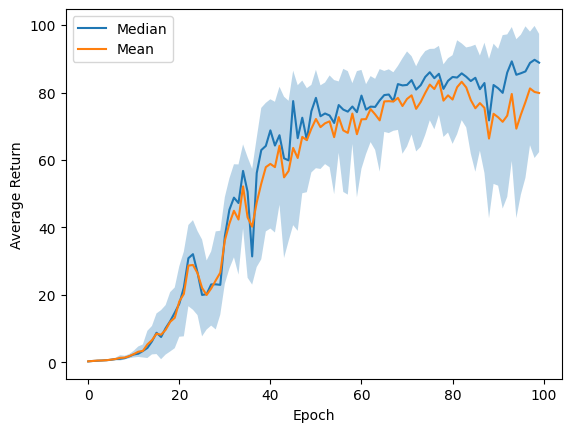

In [11]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()